<font size="14"> Credit Card Fraud Detection



* Business Problem: Detect fraud over very unbalanced data. 
* Methodology: Data analysis and modelling.
* How to use this notebook: Just execute the all the cells and show must start! 

* Notes:
    - utils.py file keeps all necessary and used functions.

In [1]:
# Usable frameworks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Suppress not usable information, to keep it clean
import warnings
warnings.filterwarnings('ignore')

In [2]:
# The utils.py file have the most usable functions to this project
from utils import *

In [3]:
# Get the credit card fraud database from Google apis 
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

# Let's see what we have here:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Peek over the base
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


We can see that:
- No null values detected.
- Class is the decision column
- Time is a little confused, we dont work with data like this, unlesse its mandatory.
- Amount have diffent dimensionality compared to other columns, lets suavize it.

In [4]:
# Removendo a coluna Time, pois ela não faz parte do business case.
df.pop('Time')

# O range de valores da coluna Amount é muito grande. Para que nenhum valor seja 0, acrescentamos 1 centavo as valores
eps = 0.001 # 0 => 0.1¢
df['Log_Ammount'] = np.log(df.pop('Amount')+eps)

In [142]:
# Checking the decision classes:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examplos:\n    Total: {}\n    Positivos: {} ({:.2f}% do Total)\n'.format(
    total, pos, 100 * pos / total))

Examplos:
    Total: 284807
    Positivos: 492 (0.17% do Total)



The classes are very, very unbalaced 😭

We're trying to be bold here, but some precautions must be made:

First we gotta know if any feature are normal distributed...

In [144]:
normality_test(df, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Log_Ammount'])

,Coluna,p_valor,Normal?
0,V1,0.000000e+00,False
1,V2,0.000000e+00,False
2,V3,0.000000e+00,False
3,V4,0.000000e+00,False
4,V5,0.000000e+00,False
5,V6,0.000000e+00,False
6,V7,0.000000e+00,False
7,V8,0.000000e+00,False
8,V9,0.000000e+00,False
9,V10,0.000000e+00,False


Thats good, all feature a non-normal distributions. 

Now, we can use a test to check if the two classes are statistical different.

In [9]:
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

differences_test(df_class_0, df_class_1, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Log_Ammount'])

,Coluna,p_valor,Different?
0,V1,0.000000e+00,False
1,V2,0.000000e+00,False
2,V3,0.000000e+00,False
3,V4,0.000000e+00,False
4,V5,0.000000e+00,False
5,V6,4.213111e-120,False
6,V7,0.000000e+00,False
7,V8,2.740673e-26,False
8,V9,0.000000e+00,False
9,V10,0.000000e+00,False


Except for V22, V23 and V25 all other features have no statistical differences between the class of frauds (1) and no-frauds (0)

It can be a problem, since similar data within different classes could cause bad performance of the model. 😓

Ok, the class data are statistical similar, but how much they're correlated?

In [11]:
# Calculating and ranking the max correlation between features

correlation_matrix = df.corr()

mean_correlation = {}

for coluna in correlation_matrix.columns:
    mean_corr = correlation_matrix[coluna].drop(coluna).mean()
    mean_correlation[coluna] = mean_corr

mean_corr_df = pd.DataFrame(list(mean_correlation.items()), columns=['Column/Feature', 'Max Correlation'])

mean_corr_df = mean_corr_df.sort_values(by='Max Correlation', ascending=False)

print("Ranking columns/features by max correlation")
print(mean_corr_df)

Ranking columns/features by max correlation
   Column/Feature  Max Correlation
19            V20         0.004972
20            V21         0.004020
10            V11         0.003908
3              V4         0.003451
5              V6         0.003445
21            V22         0.001196
18            V19         0.001056
27            V28         0.000287
7              V8         0.000207
12            V13        -0.000124
24            V25        -0.000214
25            V26        -0.000650
23            V24        -0.000696
26            V27        -0.000791
22            V23        -0.000943
14            V15        -0.001804
17            V18        -0.002458
6              V7        -0.003531
8              V9        -0.006009
0              V1        -0.006278
2              V3        -0.007584
9             V10        -0.007835
11            V12        -0.009508
13            V14        -0.009559
15            V16        -0.010002
16            V17        -0.010564
1          

Interesting, the data are statistical similar, but not correlated... maybe can work... 😒

Let's model and execute, and see the results.

In [5]:
# Setting up the trainning and validation data.

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Log_Ammount']
target = ['Class']

X = df[features].astype('float64') # Data to train validate
y = df[target].astype('float64')   # Class data 0:Not-fraud 1:Fraud 

# We will use 20% of the data to validate, and 80% to train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339


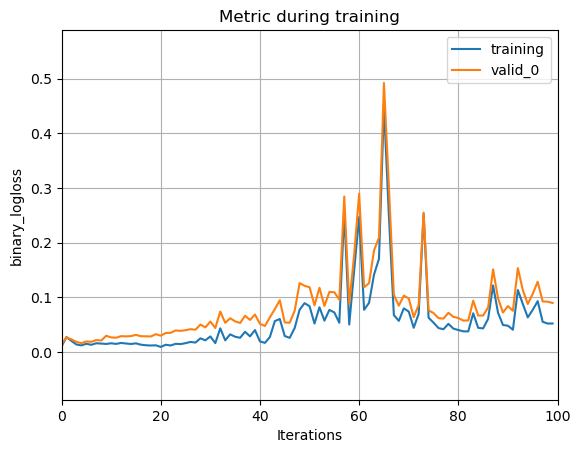

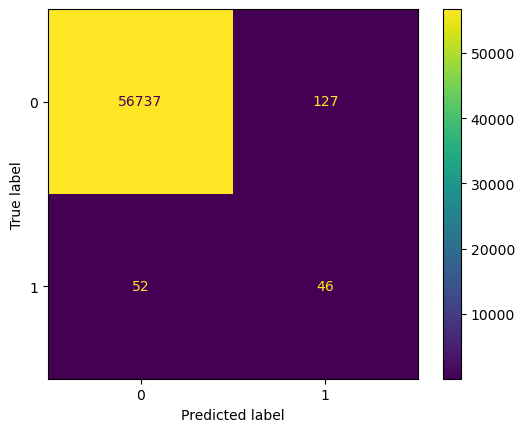

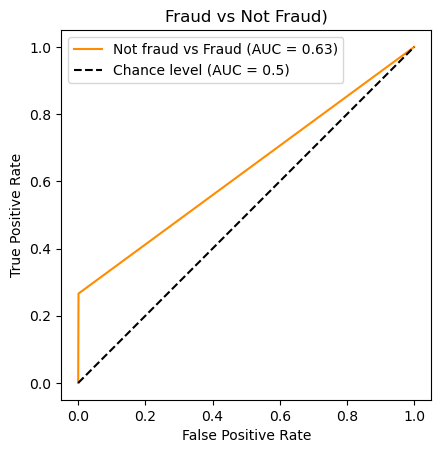

,Accuracy,F1-Score,Recall,Precision,AUC-ROC
0,0.996858,0.339483,0.469388,0.265896,0.644373


In [6]:
# Executing model with no params
model_evaluation(None, X_train, y_train, X_test, y_test)

✋🏼 Stop everything! How the accuracy can be so good with all other metrics poorly performing?

💡 Simple! Accuracy it's far the most trustable metric! Here, it haves a high value because the data is unbalanced, it's because we MUST analyze the model through all metrics, not only accuracy.

🔍Here is the problem:  Since it´s unbalanced, the decision are also imprecise for the fraud class (1). The total of 1's in the test data was 98. It predicted wrong in 52 examples, representing almost 53% of wrongly predicted data for the 1 class. According to AUROC curve we can see the model the capacity of the model in predict real frauds 63%. It´s not good, but we have ground to test opportunites of improvement here.

🗱 To improve de model capacity of deliver best result even with unbalaced data, we need first to ponder and quantify the unbalance.

In [21]:
# Unbalance weight calculation
len(y_train)/(2 * np.bincount(y_train['Class'])[1])

289.14340101522845

Now, we have the absolute weight of unbalance. The LightGBM model can be fed with this value and understand the unbalance through it and improve their results.

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341963 -> initscore=-0.654557
[LightGBM] [Info] Start training from score -0.654557


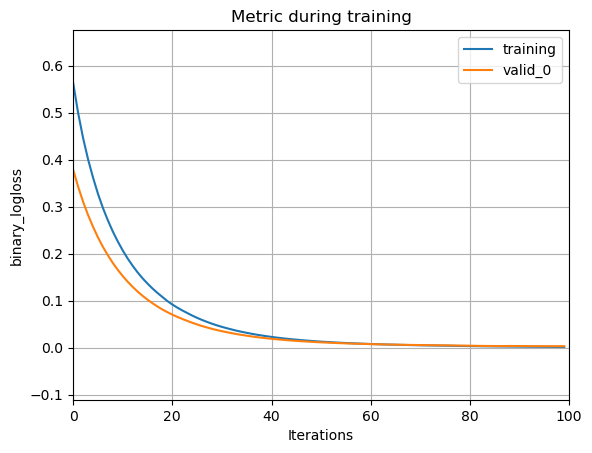

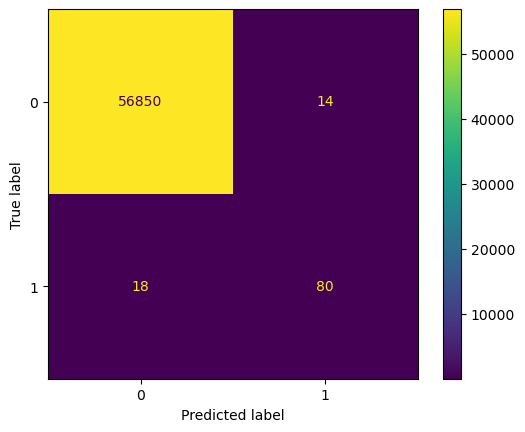

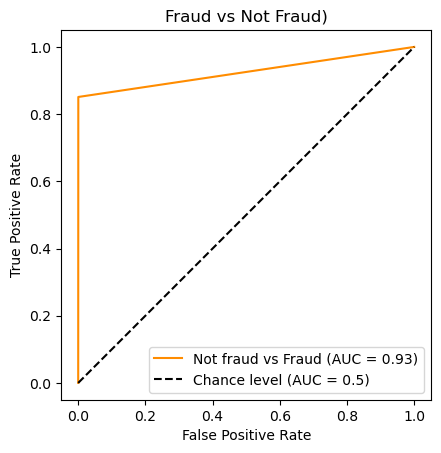

,Accuracy,F1-Score,Recall,Precision,AUC-ROC
0,0.999438,0.833333,0.816327,0.851064,0.974071


In [13]:
# Executing model with params adjustments to perform over unbalaced data
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.09,
    'class_weight': {1:300} #rounding up the weight
}

model_evaluation(params, X_train, y_train, X_test, y_test)

Thats it! Now we have a good racall of aprox 82% what means we'll detect correctly this percentual. The AUROC curve can certify this, considering it's value of more than 90%.

Take if, params, you deserve your medal: 🏅